In [2]:
import numpy as np 
import random
import matplotlib.pyplot as plt # Graphical library
import time 
from sklearn.metrics import mean_squared_error # Mean-squared error function

# Coursework 1 :
See pdf for instructions. 

In [3]:
# WARNING: fill in these two functions that will be used by the auto-marking script
# [Action required]

def get_CID():
  return "01340451" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "mjr3717" # Return your short imperial login

## Helper class

In [4]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):
    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze class

In [43]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """
    cid = get_CID()
    y = int(cid[-2])
    z = int(cid[-1])
    
    
    # [Action required]
    # Properties set from the CID
    self._prob_success = 0.8+0.02*(9-y) # float
    self._gamma = 0.8+0.02*y # float

    self._goal = z % 4 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3)

    # Build the maze
    self._build_maze()
                              

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

## DP Agent

In [44]:
# This class define the Dynamic Programing agent 

class DP_agent(object):  

  def solve(self, env):
    """
    Solve a given Maze environment using Dynamic Programming
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - V {np.array} -- Corresponding value function 
    """
    
    # Initialisation (can be edited)
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    V = np.zeros(env.get_state_size())
    gamma = env.get_gamma()
    threshold = 0.0001
    delta = 2 * threshold
    epochs = 0

    
    policy[:, 0] = 1 
    policy_stable = False 
    tic = time.time()

    while delta >= threshold:
      epochs += 1
      delta = 0
      v_old = np.copy(V)
      P = env.get_T()
      R_t = env.get_R()
      C = gamma * V
      new_V = np.amax((np.einsum('spa,spa->sa',P, R_t) + np.einsum('spa,p->sa',P,C)), axis = 1)
      delta = max(abs(v_old-new_V))
      V = new_V      

    optimal_policy = np.zeros((env.get_state_size(), env.get_action_size()))
    P = env.get_T()
    R_t = env.get_R()
    C = gamma * V
    new_pi = np.argmax(np.einsum('spa,spa->sa',P, R_t) + np.einsum('spa,p->sa',P,C), axis = 1)
    for i in range(len(new_pi)):
      optimal_policy[i][new_pi[i]] = 1
    policy = optimal_policy

    print("epochs: ", epochs)

    toc = time.time()
    print("Time: ", toc-tic)
  
    return policy, V

## MC agent

In [45]:
# This class define the Monte-Carlo agent

class MC_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script

  def get_action(self, Q_state, epsilon):
    max_val = np.argmax(Q_state)
    rand_val = np.random.uniform(0,1)
    if rand_val < (1-epsilon):
      return max_val
    else:
      options = []
      for idx in range(len(Q_state)):
        if idx != max_val:
          options.append(idx)
      return np.random.choice(options)


  def solve(self, env, epsilon = 0.05, alpha = 0.1, num_runs = 500 ):
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    gamma = env.get_gamma()
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    # policy[:, 0] = np.argmax(Q, axis=1)
    
    for state in range(len(Q)):
      policy[state] + epsilon
      policy[state][0] = 1 - (2*epsilon) + epsilon / (len(policy[state]))

    p_init = 0.5
    p_end = 0.01
    fin = 200

    # total_rewards = [[[] for i in range(env.get_action_size())] for j in range(env.get_state_size())]
    total_returns = [[[0,0] for i in range(env.get_action_size())] for j in range(env.get_state_size())]
    total_rewards = np.zeros((num_runs, 1))
    run = 0

    while run < num_runs:
      #alpha = (num_runs - run) / num_runs
      #epsilon = max(((p_init - p_end) * ((fin - run)/fin)),0) + p_end


      visited = {}
      run += 1
      time, env_state, reward, Terminate = env.reset()
      S_arr = np.array([], dtype = int)      
      A_arr = np.array([], dtype = int)
      R_arr = np.array([], dtype = int)
      R_arr = np.append(R_arr, 0)

      while not Terminate:
        action = self.get_action(Q[env_state], epsilon)
        S_arr = np.append(S_arr, env_state)
        A_arr = np.append(A_arr, action)
        sa_pair = (env_state, action) 
        if sa_pair not in visited:
          visited[sa_pair] = time

        time, env_state, reward, Terminate = env.step(action)
        R_arr = np.append(R_arr, reward) 
        
      total_rewards[run-1] += np.sum(R_arr)

      G = 0
      T = len(S_arr)

      for t in range(T-1, -1, -1):

        St = S_arr[t]; At = A_arr[t]
        
        # G = G + R_arr[t+1]
        G = (G * gamma) + R_arr[t+1]

        total_returns[St][At][0] += 1
        # total_returns[St][At][1] = total_returns[St][At][1] + ((G - total_returns[St][At][1]) / total_returns[St][At][0])
        total_returns[St][At][1] = total_returns[St][At][1] + ((G - total_returns[St][At][1]) * alpha)

        Q[St][At] = total_returns[St][At][1]

        best_action = np.argmax(Q[St])
        V[St] = np.max(Q[St])
        for a in range(len(Q[St])):
          if a == best_action:
            policy[St][a] = 1 - epsilon + (epsilon/len(Q[St]))
          else:
            policy[St][a] = (epsilon/len(Q[St]))

    for j in range(len(Q)):
      V[j] = np.max(Q[j])
    values = [V]
    
    return policy, values, total_rewards

## TD agent

In [65]:
# This class define the Temporal-Difference agent

class TD_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script

  def get_action(self, Q_state, epsilon):
    max_val = np.argmax(Q_state)
    rand_val = np.random.uniform(0,1)
    if rand_val < (1-epsilon):
      return max_val
    else:
      options = []
      for idx in range(len(Q_state)):
        if idx != max_val:
          options.append(idx)
      return np.random.choice(options)

  def solve(self, env, epsilon = 0.05, alpha = 0.1, num_runs = 500):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    values = [V]
    total_rewards = []
    total_rewards = np.zeros((num_runs, 1))
    gamma = env.get_gamma()
    run = 0

    p_init = 0.5
    p_end = 0.01
    fin = 200
    
    while run < num_runs: 
      # alpha = (num_runs - run) / num_runs
      # epsilon = max(((p_init - p_end) * ((fin - run)/fin)),0) + p_end
      run += 1
      
      time, old_state, reward, Terminate = env.reset()
      old_action = self.get_action(Q[old_state], epsilon)
      while not Terminate:
        
        time, new_state, reward, Terminate = env.step(old_action)
        new_action = self.get_action(Q[new_state], epsilon)
        # new_action = np.argmax(Q[new_state])
        total_rewards[run-1] += reward
        Q[old_state][old_action] = Q[old_state][old_action] + (alpha * (reward + (gamma*Q[new_state][new_action]) - Q[old_state][old_action]))
        
        old_state = new_state 
        old_action = new_action

    values = [np.max(Q, axis = 1)]
    for state in range(len(Q)):
      policy[state][np.argmax(Q[state])] = 1

    return policy, values, total_rewards

## Example main

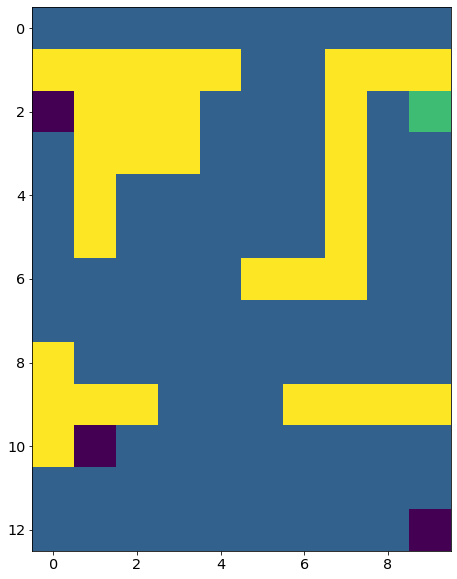

epochs:  48
Time:  0.007462739944458008
Results of the DP agent:



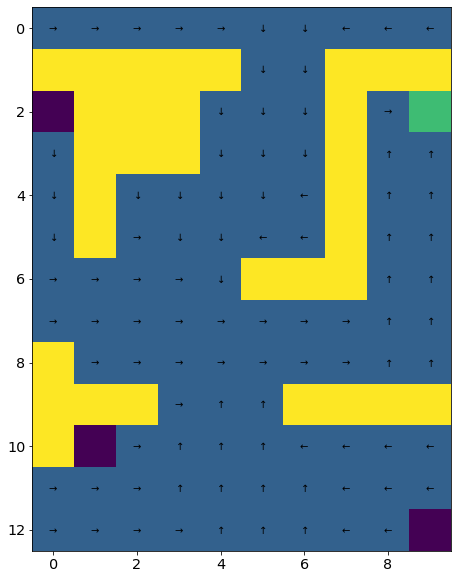

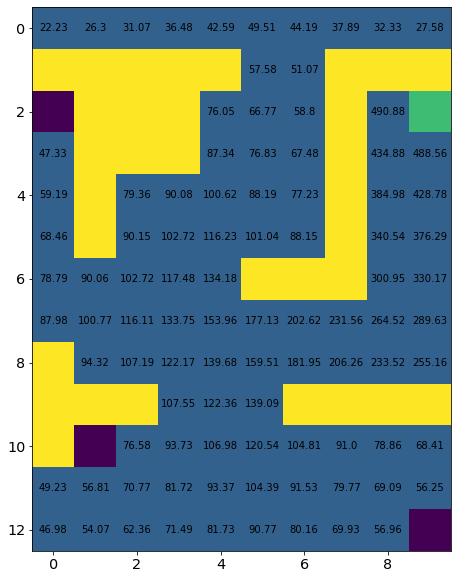

Results of the MC agent:



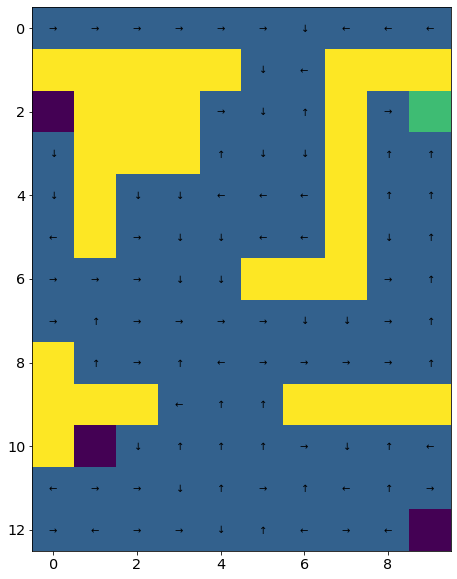

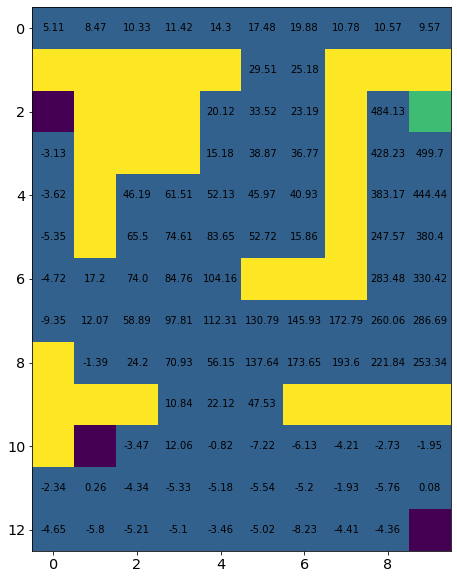

Results of the TD agent:



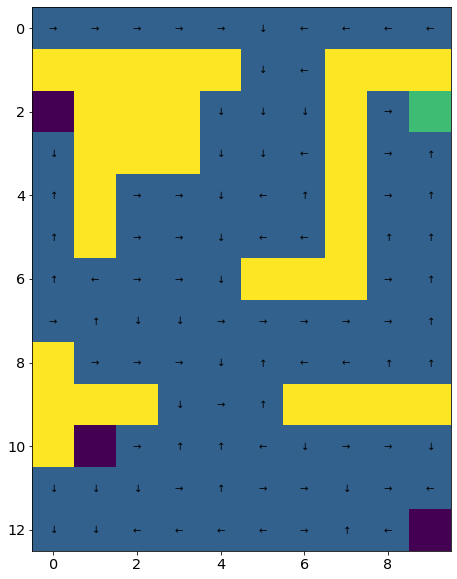

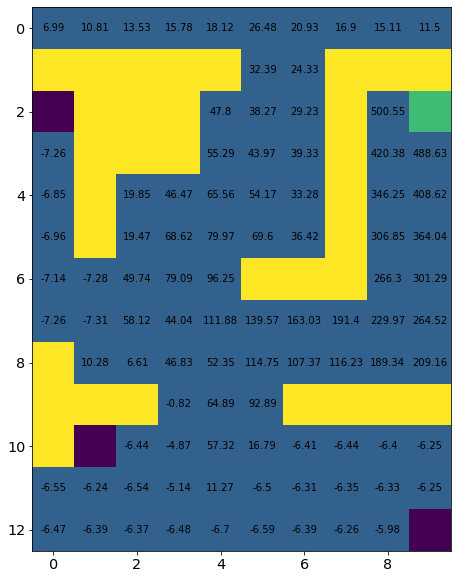

In [12]:
# Example main (can be edited)

### Question 0: Defining the environment

# print("Creating the Maze:\n")
maze = Maze()


# ### Question 1: Dynamic programming

dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)

print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)


# # ### Question 2: Monte-Carlo learning

mc_agent = MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])
# # print("policy: ", mc_policy)
# # print('total rewards: ', total_rewards)
# # print("mc value: ", mc_values)


# # ### Question 3: Temporal-Difference learning

td_agent = TD_agent()
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])

In [29]:
# PLOTTING TOTAL REWARDS BY EPISODE FOR MC
# PLOTTING AVERAGE VALUE FUNCTION BY EPISODE FOR MC
# Question 2 part 2
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def mc_changerep_plot(reps):
    tot_ret = [0 for i in range(reps)]
    for repeats in range(reps):
        mc_agent = MC_agent()
        _, values, total_rwd = mc_agent.solve(maze)
        tot_ret[repeats] += total_rwd
    tot_ret = np.asarray(tot_ret)
    y = np.mean(tot_ret, axis = 0)
    errs = np.std(tot_ret, axis = 0, dtype = float).flatten()
    running_mean = [np.mean(y[-100:]) for i in range(len(y))]
    x = [i for i in range(len(y))]
    return x, y, values, running_mean, errs

# reps = [1, 5, 10, 25, 50, 100, 125, 150, 200, 250, 500]
reps = [1, 5, 10, 20, 25, 30, 35, 40, 50, 500]

xs = [] 
ys = []
vs = []
errs = []
for repeats in reps:
    x, y, v, _, err = mc_changerep_plot(repeats)
    xs.append(x)
    ys.append(y)
    vs.append(np.mean(v[0]))
    errs.append(err)
    print(f"Done with {repeats} repeats")

colors = ['blue', 'teal', 'orange', 'pink', 'green', ]
for plots in range(len(xs)-1):
    plt.plot(xs[plots][0:500], ys[plots][0:500], linestyle = '--', linewidth = (0.3 + (0.1*plots)),label = f'{reps[plots]} repeat(s)')
    # plt.errorbar(xs[plots][0:500], ys[plots][0:500], linestyle = '--',linewidth = 0.2, yerr = errs[plots][0:500])
    # plt.plot(x[0:500], running_mean[0:500], color = 'red', linewidth = 2)

plt.plot(xs[-1][0:500], ys[-1][0:500], linewidth = 1.2,label = f'{reps[-1]} repeat(s)', color = 'black')
plt.errorbar(xs[-1][0:500], ys[-1][0:500], linewidth = 0.2,color = 'black', yerr = errs[-1][0:500])

plt.legend( fontsize = 20, markerscale = 3)
plt.xlabel('No. Episodes', fontsize = 22)
plt.ylabel('Total Non-discounted Episode Return', fontsize = 22)
plt.savefig('Q2 2 focus around 30 repeats.jpg')
plt.show()

plt.figure()
plt.xlabel('No. Episodes', fontsize = 22)
plt.ylabel('Total Non-discounted Episode Return', fontsize = 22)
plt.plot(xs[3][0:500], ys[3][0:500], linewidth = 0.6,label = '20 repeat(s)',linestyle='-.')
plt.plot(xs[4][0:500], ys[4][0:500], linewidth = 0.7,label = '25 repeat(s)',linestyle='-.')
plt.plot(xs[5][0:500], ys[5][0:500], linewidth = 0.9,label = '30 repeat(s)',linestyle='-.')
plt.plot(xs[6][0:500], ys[6][0:500], linewidth = 1.1,label = '35 repeat(s)',linestyle='-.')
plt.plot(xs[-1][0:500], ys[-1][0:500], linewidth = 1.3,label = '500 repeat(s)',linestyle='-.', color = 'black')
plt.legend(fontsize = 20, markerscale = 3)
# plt.savefig('Q2 2 focus just 2 bits.jpg')

plt.figure()
plt.xlabel('No. Episodes', fontsize = 22)
plt.ylabel('Total Non-discounted Episode Return', fontsize = 22)
plt.plot(xs[5][0:500], ys[5][0:500], linewidth = 1.0,label = '30 repeat(s)',linestyle='-.')
plt.errorbar(xs[5][0:500], ys[5][0:500], yerr = errs[5][0:500], linewidth = 0.4,linestyle='-.', capsize = 1, color = 'black')
plt.legend(fontsize = 20, markerscale = 3)
# plt.savefig('Q2 just 30 repeats.jpg')






Done with 1 repeats
Done with 5 repeats
Done with 10 repeats


KeyboardInterrupt: 

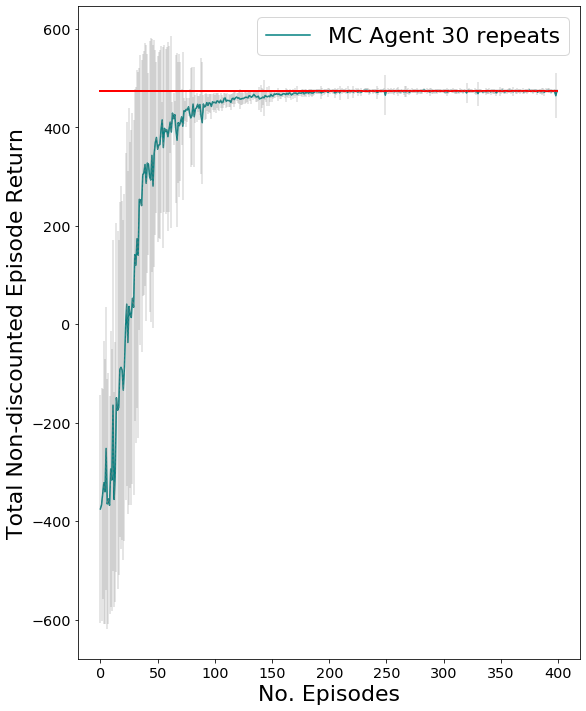

In [26]:
# PLOTTING TOTAL REWARDS BY EPISODE FOR MC

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
end = 400
reps = 30

# tot_ret_mc = [0 for i in range(reps)]
# for repeats in range(reps):
#     mc_agent = MC_agent()
#     _, _, total_rwd = mc_agent.solve(maze, num_runs = 1000)
#     tot_ret_mc[repeats] += total_rwd
#     print(f"Done with repeat {repeats}")


tot_ret_mc = np.asarray(tot_ret_mc)
y_mc = np.mean(tot_ret_mc, axis = 0)
errs_mc = np.std(tot_ret_mc, axis = 0, dtype = float).flatten()
final_mean_mc = [np.mean(y_mc[-50:]) for i in range(len(y_mc))]
x_mc = [i for i in range(len(y_mc))]

plt.plot(x_mc[0:end], y_mc[0:end], color = 'teal',label = 'MC Agent 30 repeats')
plt.errorbar(x_mc[0:end], y_mc[0:end], linestyle = '-.',linewidth = 0.4, yerr = errs_mc[0:end], color = 'grey')
plt.plot(x_mc[0:end], final_mean_mc[0:end], color = 'red', linewidth = 2)
plt.xlabel('No. Episodes', fontsize = 22)
plt.ylabel('Total Non-discounted Episode Return', fontsize = 22)
plt.legend(fontsize = 22)
plt.savefig('Q2 part 4 30 repeats.png')

In [28]:
# PLOTTING TOTAL REWARDS BY EPISODE FOR MC
# THE DISGUSTING ONE LMAO



# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (9, 12),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
# pylab.rcParams.update(params)
# end = 5000
# reps = 3
# tot_ret_mc = [0 for i in range(reps)]
# for repeats in range(reps):
#     mc_agent = MC_agent()
#     _, _, total_rwd = mc_agent.solve(maze)
#     tot_ret_mc[repeats] += total_rwd
# tot_ret_mc = np.asarray(tot_ret_mc)

# y_mc = np.mean(tot_ret_mc, axis = 0)
# errs_mc = np.std(tot_ret_mc, axis = 0, dtype = float).flatten()
# final_mean_mc = [np.mean(y_mc[-100:]) for i in range(len(y_mc))]
# running_mean_mc = [np.mean(y_mc[0:i+1]) for i in range(len(y_mc))]
# running_std_mc = [np.std(y_mc[0:i+1]) for i in range(len(y_mc))]
# x_mc = [i for i in range(len(y_mc))]

# plt.plot(x_mc[0:end], y_mc[0:end], color = 'black', label = 'Total Return of Episode')
# # plt.errorbar(x_mc[0:end], y_mc[0:end], linestyle = '-.',linewidth = 0.3, yerr = errs_mc[0:end], color = 'blue')
# plt.plot(x_mc[0:end], final_mean_mc[0:end], color = 'red', linewidth = 2)
# plt.plot(x_mc[0:end], running_mean_mc[0:end], label = 'Mean Return')
# plt.plot(x_mc[0:end], running_std_mc[0:end], label = 'Standard Deviation $\sigma$')
# plt.legend( fontsize = 20, markerscale = 3)
# plt.xlabel('No. Episodes', fontsize = 22)
# plt.ylabel('Total Non-discounted Episode Return', fontsize = 22)



Done with $\epsilon$ = 0.005
Done with $\epsilon$ = 0.01
Done with $\epsilon$ = 0.1
Done with $\epsilon$ = 0.2
Done with $\epsilon$ = 0.5
Done with $\epsilon$ = 0.95


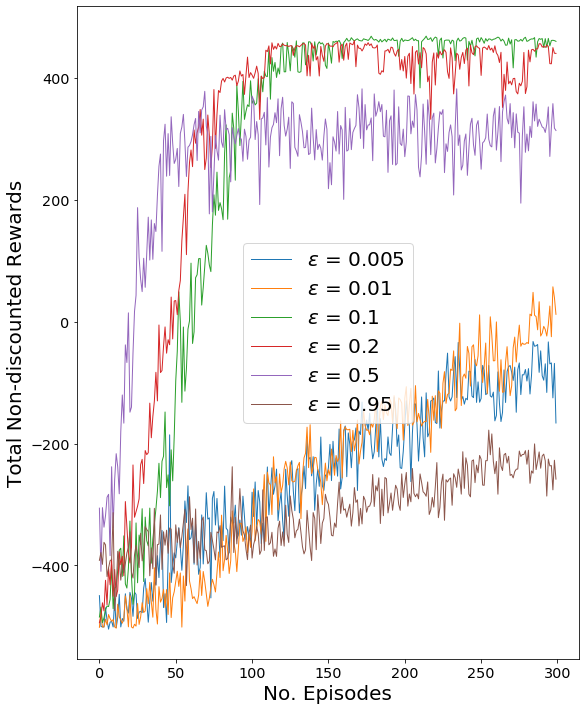

In [42]:
# Question 2 part 5, change epsilon 
epsilons = [0.005,0.01,  0.1, 0.2, 0.5, 0.95]
reps = 20
end = 300

def mc_change_epsilon_plot(reps, var):
    # maze = Maze()
    tot_ret = [0 for i in range(reps)]
    for repeats in range(reps):
        mc_agent = MC_agent()
        _, values, total_rwd = mc_agent.solve(maze, epsilon = var)
        tot_ret[repeats] += total_rwd
    tot_ret = np.asarray(tot_ret)
    y = np.mean(tot_ret, axis = 0)
    errs = np.std(tot_ret, axis = 0, dtype = float).flatten()
    running_mean = [np.mean(y[-100:]) for i in range(len(y))]
    x = [i for i in range(len(y))]
    return x, y, values, running_mean, errs



eps = [[] for i in range(len(epsilons))]
for ep in range(len(epsilons)):
    eps_x, eps_y, eps_v, _, eps_err = mc_change_epsilon_plot(reps, epsilons[ep])
    eps[ep] = (eps_x, eps_y, eps_v, eps_err)
    print(f"Done with $\epsilon$ = {epsilons[ep]}")
    


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure()
plt.xlabel('No. Episodes', fontsize = 20)
plt.ylabel('Total Non-discounted Rewards', fontsize = 20)

for i in range(len(eps)):
    plt.plot(eps[i][0][0:end], eps[i][1][0:end], linewidth = (1.0 ), label = f'$\epsilon$ = {epsilons[i]}')

    
plt.legend(fontsize = 20)
plt.savefig('Q2 5 changing eplison 40 reps with epsilon 1.png')

# error_testing = list(map(la   mbda x: mean_squared_error(x[0][2][0], dp_value), eps))
# plt.figure()
# plt.xlabel('No. Episodes')
# plt.ylabel('MSE')
# for i in range(len(eps)):
#     plt.plot(eps[i][0], mean_squared_error(eps[i][2][0], dp_value), linewidth = (0.1 + (0.1 * i)), label = f'$\epsilon$ = {epsilons[i]}')
# plt.legend()


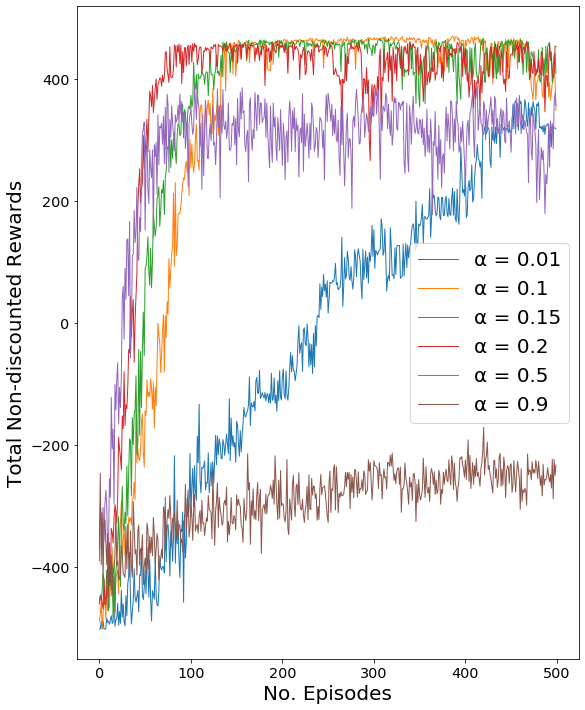

In [50]:
# Question 2 part 5, change alpha 
# alphas = [0.005,0.01, 0.1, 0.25, 0.5, 0.7, 0.9, 0.99]
alphas = [0.01, 0.1, 0.15, 0.2, 0.5, 0.9]
reps = 20
end = 500

def mc_change_alpha_plot(reps, var):
    tot_ret = [0 for i in range(reps)]
    for repeats in range(reps):
        mc_agent = MC_agent()
        _, values, total_rwd = mc_agent.solve(maze, epsilon = var)
        tot_ret[repeats] += total_rwd
    tot_ret = np.asarray(tot_ret)
    y = np.mean(tot_ret, axis = 0)
    errs = np.std(tot_ret, axis = 0, dtype = float).flatten()
    running_mean = [np.mean(y[-100:]) for i in range(len(y))]
    x = [i for i in range(len(y))]
    return x, y, values, running_mean, errs

# alphs = [[] for i in range(len(alphas))]
# for alph in range(len(alphas)):
#     alph_x, alph_y, alph_v, _, alph_err = mc_change_alpha_plot(reps, alphas[alph])
#     alphs[alph] = (alph_x, alph_y, alph_v, alph_err)
    

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure()
plt.xlabel('No. Episodes', fontsize = 20)
plt.ylabel('Total Non-discounted Rewards', fontsize = 20)

for i in range(len(alphs)):
    plt.plot(alphs[i][0][0:end], alphs[i][1][0:end], linewidth = 1, label = f'α = {alphas[i]}')

plt.legend(fontsize = 20)
# plt.savefig('Q2 5 changing alpha 70 reps.png')



Red value:  475.38449999999995


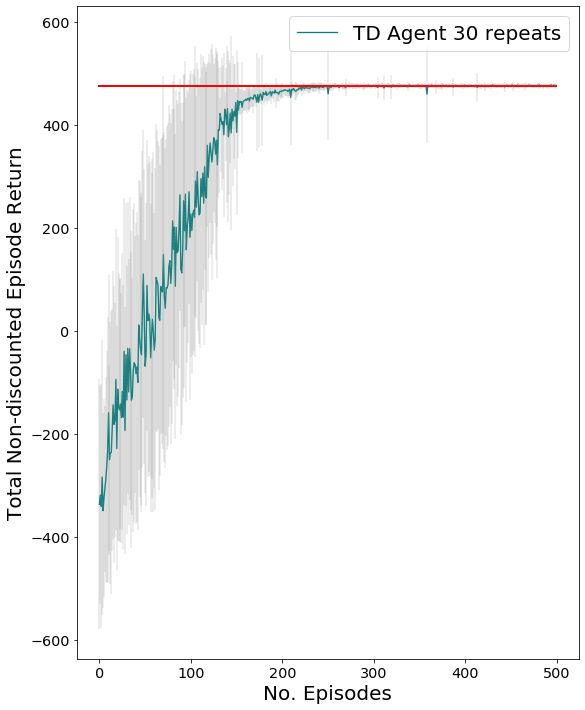

In [60]:
# PLOTTING TOTAL REWARDS BY EPISODE FOR TD

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

reps = 40
# tot_ret_td = [0 for i in range(reps)]
# for repeats in range(reps):
#     # maze = Maze()
#     td_agent = TD_agent()
#     _, _, total_rwd = td_agent.solve(maze)
#     tot_ret_td[repeats] += total_rwd
# tot_ret_td = np.asarray(tot_ret_td)


y_td = np.mean(tot_ret_td, axis = 0)
errs_td = np.std(tot_ret_td, axis = 0, dtype = float).flatten()
running_mean_td = [np.mean(y_td[-100:]) for i in range(len(y_td))]
x_td = [i for i in range(len(y_td))]
fhd = [500 for i in range(len(x_td))]

plt.plot(x_td[0:500], y_td[0:500], color = 'teal', linewidth = 1.3, label = 'TD Agent 30 repeats')
plt.errorbar(x_td[0:500], y_td[0:500], linestyle = '-.',linewidth = 0.3, yerr = errs_td[0:500], color = 'grey')
plt.plot(x_td[0:500], running_mean_td[0:500], color = 'red', linewidth = 2)
# plt.plot(x_td[0:500], fhd[0:500], color = 'orange', linewidth = 2)
print("Red value: ", running_mean_td[-5])
plt.xlabel('No. Episodes', fontsize=20)
plt.ylabel('Total Non-discounted Episode Return', fontsize=20)
plt.legend(fontsize = 20)
plt.savefig('Q3 3 40 reps fixed alpha.png')


Done with $\epsilon$ = 0.005
Done with $\epsilon$ = 0.01
Done with $\epsilon$ = 0.1
Done with $\epsilon$ = 0.2
Done with $\epsilon$ = 0.5
Done with $\epsilon$ = 0.7
Done with $\epsilon$ = 0.9


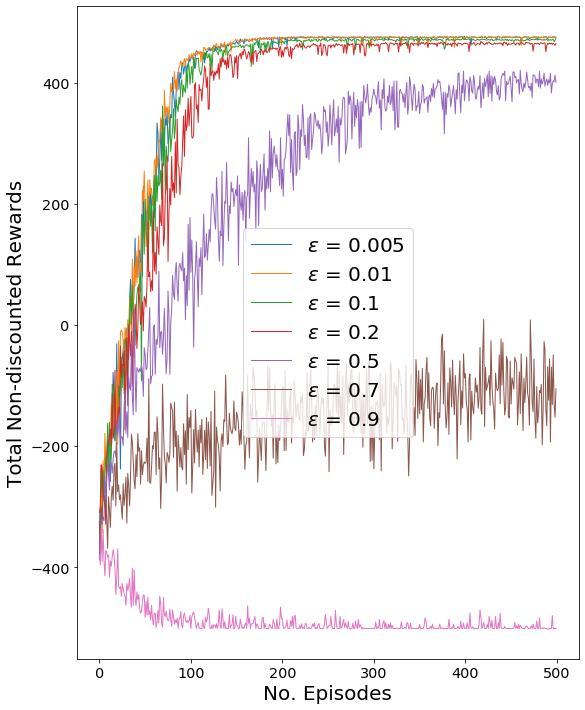

In [67]:
# Question 3 part 4, change epsilon TD
epsilons = [0.005,0.01,  0.1, 0.2, 0.5, 0.7, 0.9]
reps = 40
end = 600
# maze = Maze()

def td_change_epsilon_plot(reps, var):
    tot_ret = [0 for i in range(reps)]
    for repeats in range(reps):
        td_agent = TD_agent()
        _, values, total_rwd = td_agent.solve(maze, epsilon = var)
        tot_ret[repeats] += total_rwd
    tot_ret = np.asarray(tot_ret)
    y = np.mean(tot_ret, axis = 0)
    errs = np.std(tot_ret, axis = 0, dtype = float).flatten()
    running_mean = [np.mean(y[-100:]) for i in range(len(y))]
    x = [i for i in range(len(y))]
    return x, y, values, running_mean, errs

eps_td = [[] for i in range(len(epsilons))]
for ep in range(len(epsilons)):
    eps_x, eps_y, eps_v, run_mean, eps_err = td_change_epsilon_plot(reps, epsilons[ep])
    eps_td[ep] = (eps_x, eps_y, eps_v, eps_err, run_mean)
    print(f"Done with $\epsilon$ = {epsilons[ep]}")
    

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure()
plt.xlabel('No. Episodes', fontsize = 20)
plt.ylabel('Total Non-discounted Rewards', fontsize = 20)

for i in range(len(eps_td)):
    plt.plot(eps_td[i][0][0:end], eps_td[i][1][0:end], linewidth = (1.0 ), label = f'$\epsilon$ = {epsilons[i]}')
    # plt.errorbar(eps_td[i][0][0:end], eps_td[i][1][0:end], yerr=eps_td[i][2][0:end], linewidth = 0.1)

    
plt.legend(fontsize = 20)
plt.savefig('Q3 4 changing eplison large epsilon 40 reps.png')



Mean of last 100 for α=0.01: 199.86499999999995
Mean of last 100 for α=0.1: 473.3424999999999
Mean of last 100 for α=0.15: 473.24899999999985
Mean of last 100 for α=0.2: 472.719
Mean of last 100 for α=0.5: 470.43699999999984
Mean of last 100 for α=0.95: 437.8539999999999


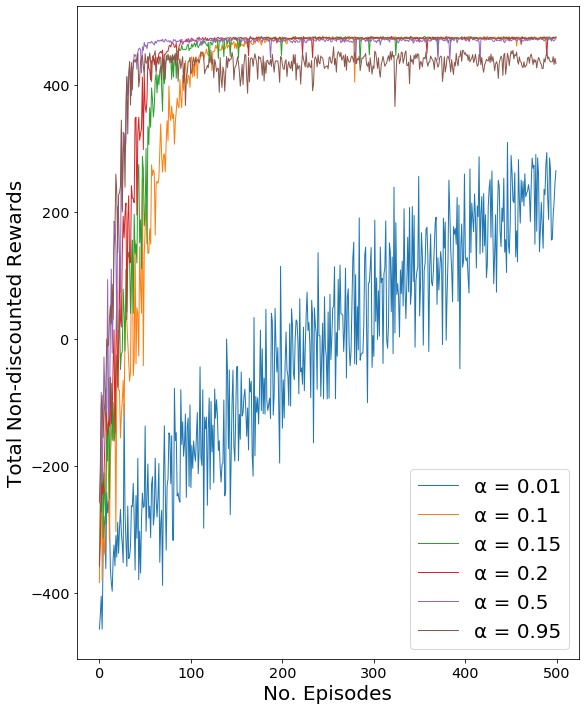

In [76]:
# Question 3 part 4, change alphas 
alphas = [0.01, 0.1, 0.15, 0.2, 0.5, 0.95]
reps = 20
end = 600
# maze = Maze()

def td_change_alpha_plot(reps, var):
    tot_ret = [0 for i in range(reps)]
    for repeats in range(reps):
        td_agent = TD_agent()
        _, values, total_rwd = td_agent.solve(maze, alpha = var)
        tot_ret[repeats] += total_rwd
    tot_ret = np.asarray(tot_ret)
    y = np.mean(tot_ret, axis = 0)
    errs = np.std(tot_ret, axis = 0, dtype = float).flatten()
    running_mean = [np.mean(y[-100:]) for i in range(len(y))]
    x = [i for i in range(len(y))]
    return x, y, values, running_mean, errs

# alphs_td = [[] for i in range(len(alphas))]
# for ep in range(len(alphas)):
#     eps_x, eps_y, eps_v, _, eps_err = td_change_alpha_plot(reps, alphas[ep])
#     alphs_td[ep] = (eps_x, eps_y, eps_v, eps_err)
#     print(f"Done with alpha = {alphas[ep]}")
    

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure()
plt.xlabel('No. Episodes', fontsize = 20)
plt.ylabel('Total Non-discounted Rewards', fontsize = 20)

for i in range(len(alphs_td)):
    plt.plot(alphs_td[i][0][0:end], alphs_td[i][1][0:end], linewidth = (1.0 ), label = f'α = {alphas[i]}')

    
plt.legend(fontsize = 20)
plt.savefig('Q3 4 changing alpha 70 reps.png')


for i in range(len(alphs_td)):
    print(f"Mean of last 100 for α={alphas[i]}: {np.mean(alphs_td[i][1][-100:])}")

# error_testing = list(map(lambda x: mean_squared_error(x[0][2][0], dp_value), eps))
# plt.figure()
# plt.xlabel('No. Episodes')
# plt.ylabel('MSE')
# for i in range(len(eps)):
#     plt.plot(eps[i][0], mean_squared_error(eps[i][2][0], dp_value), linewidth = (0.1 + (0.1 * i)), label = f'$\epsilon$ = {epsilons[i]}')
# plt.legend()


In [77]:
# This class define the Monte-Carlo agent

class MC_agent_new(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script

  def get_action(self, Q_state, epsilon):
    max_val = np.argmax(Q_state)
    rand_val = np.random.uniform(0,1)
    if rand_val < (1-epsilon):
      return max_val
    else:
      options = []
      for idx in range(len(Q_state)):
        if idx != max_val:
          options.append(idx)
      return np.random.choice(options)


  def solve(self, env, epsilon = 0.05, alpha = 0.1, num_runs = 500 ):
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    values = [V]
    gamma = env.get_gamma()
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    
    p_init = 0.5
    p_end = 0.01
    fin = 200

    for state in range(len(Q)):
      policy[state] + epsilon
      policy[state][0] = 1 - (2*epsilon) + epsilon / (len(policy[state]))

    # total_rewards = [[[] for i in range(env.get_action_size())] for j in range(env.get_state_size())]
    total_returns = [[[0,0] for i in range(env.get_action_size())] for j in range(env.get_state_size())]
    total_rewards = np.zeros((num_runs, 1))
    run = 0
    while run < num_runs:
      alpha = (num_runs - run) / num_runs
      epsilon = max(((p_init - p_end) * ((fin - run)/fin)),0) + p_end
      visited = {}
      run += 1
      time, env_state, reward, Terminate = env.reset()
      S_arr = np.array([], dtype = int)      
      A_arr = np.array([], dtype = int)
      R_arr = np.array([], dtype = int)
      R_arr = np.append(R_arr, 0)

      while not Terminate:
        action = self.get_action(Q[env_state], epsilon)
        S_arr = np.append(S_arr, env_state)
        A_arr = np.append(A_arr, action)
        sa_pair = (env_state, action) 
        if sa_pair not in visited:
          visited[sa_pair] = time

        time, env_state, reward, Terminate = env.step(action)
        R_arr = np.append(R_arr, reward) 
        
      total_rewards[run-1] += np.sum(R_arr)

      G = 0
      T = len(S_arr)

      for t in range(T-1, -1, -1):

        St = S_arr[t]; At = A_arr[t]
        
        # G = G + R_arr[t+1]
        G = (G * gamma) + R_arr[t+1]

        total_returns[St][At][0] += 1
        # total_returns[St][At][1] = total_returns[St][At][1] + ((G - total_returns[St][At][1]) / total_returns[St][At][0])
        total_returns[St][At][1] = total_returns[St][At][1] + ((G - total_returns[St][At][1]) * alpha)

        Q[St][At] = total_returns[St][At][1]

        best_action = np.argmax(Q[St])
        V[St] = np.max(Q[St])

        for a in range(len(Q[St])):
          if a == best_action:
            policy[St][a] = 1 - epsilon + (epsilon/len(Q[St]))
          else:
            policy[St][a] = (epsilon/len(Q[St]))

      for j in range(len(Q)):
        V[j] = np.max(Q[j])
      new_V = np.einsum('sa, sa->s',Q, policy)
      values.append(new_V)

    return policy, values, total_rewards

# This class define the Temporal-Difference agent

class TD_agent_new(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script

  def get_action(self, Q_state, epsilon):
    max_val = np.argmax(Q_state)
    rand_val = np.random.uniform(0,1)
    if rand_val < (1-epsilon):
      return max_val
    else:
      options = []
      for idx in range(len(Q_state)):
        if idx != max_val:
          options.append(idx)
      return np.random.choice(options)

  def solve(self, env, epsilon = 0.05, alpha = 0.1, num_runs = 500):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    values = [V]
    total_rewards = []
    total_rewards = np.zeros((num_runs, 1))
    gamma = env.get_gamma()
    run = 0
    p_init = 0.5
    p_end = 0.01
    fin = 200
    
    while run < num_runs: 
      alpha = (num_runs - run) / num_runs
      epsilon = max(((p_init - p_end) * ((fin - run)/fin)),0) + p_end
      run += 1
      
      time, old_state, reward, Terminate = env.reset()
      old_action = self.get_action(Q[old_state], epsilon)
      tot_rwd_intermediate = 0
      while not Terminate:
        
        time, new_state, reward, Terminate = env.step(old_action)
        new_action = self.get_action(Q[new_state], epsilon)
        # new_action = np.argmax(Q[new_state])
        tot_rwd_intermediate += reward
        Q[old_state][old_action] = Q[old_state][old_action] + (alpha * (reward + (gamma*Q[new_state][new_action]) - Q[old_state][old_action]))
        
        old_state = new_state 
        old_action = new_action
      total_rewards[run-1] += tot_rwd_intermediate
      values.append(np.max(Q, axis = 1))

    for state in range(len(Q)):
      policy[state][np.argmax(Q[state])] = 1

    return policy, values, total_rewards

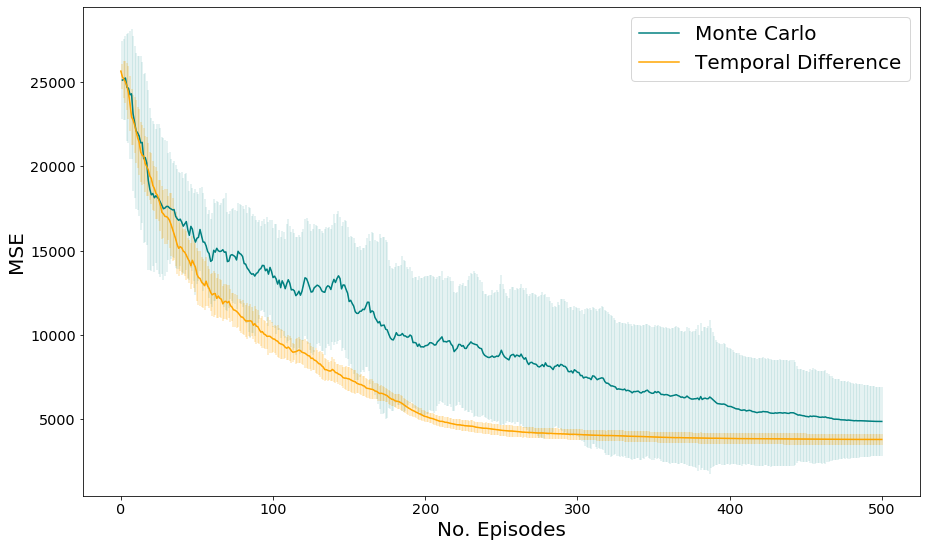

In [84]:
# QUESTION 4 PART 1

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure()

repeats = 30
episodes = 1000

eps = [i for i in range(episodes)]
# errs_mc = [[] for i in range(episodes+1)]
# errs_td = [[] for i in range(episodes+1)]
# for j in range(repeats):
#     td_agent = TD_agent_new()
#     mc_agent = MC_agent_new()
#     policy_mc, values_mc, total_rewards_mc = mc_agent.solve(maze)
#     policy_td, values_td, total_rewards_td = td_agent.solve(maze)
#     for p in range(len(values_mc)):
#         test_val = mean_squared_error(dp_value, values_mc[p])
#         errs_mc[p].append(mean_squared_error(dp_value, values_mc[p]))
#     for p in range(len(values_td)):
#         errs_td[p].append(mean_squared_error(dp_value, values_td[p]))
# err_means_mc = [0 for i in range(episodes)] #np.mean(errs_mc, axis = 1)
# err_std_mc = [0 for i in range(episodes)] #np.std(errs_mc, axis = 1)
# err_means_td = [0 for i in range(episodes)] #np.mean(errs_td, axis = 1)
# err_std_td = [0 for i in range(episodes)] #np.std(errs_td, axis = 1)
# for i in range(len(errs_mc)-1):
#     err_means_mc[i] += np.mean(errs_mc[i])
#     err_means_td[i] += np.mean(errs_td[i])
#     err_std_mc[i] += np.std(errs_mc[i])
#     err_std_td[i] += np.std(errs_td[i])


plt.xlabel('No. Episodes', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)
plt.plot(eps[1:], err_means_mc[1:], color = 'teal', label = 'Monte Carlo')
plt.errorbar(eps[1:], err_means_mc[1:], yerr = err_std_mc[1:], linewidth = 0.2, color = 'teal')

plt.plot(eps, err_means_td, color = 'orange', label = 'Temporal Difference')
plt.errorbar(eps, err_means_td, yerr = err_std_td, color = 'orange', linewidth = 0.4)
plt.legend(fontsize = 20)
plt.savefig('Q4 part 1 1000 eps wider.png')



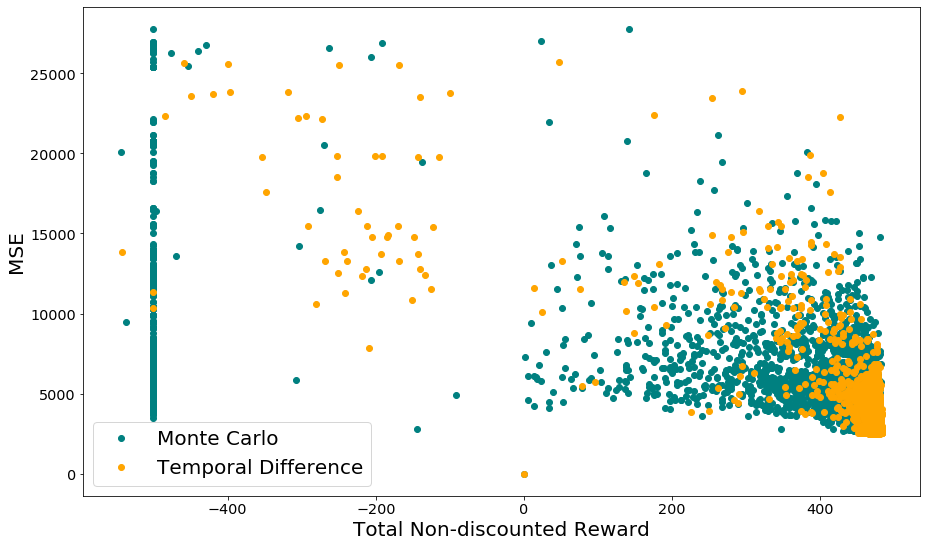

In [87]:
# Question 4 part 3
repeatingvals = 5000
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.figure()

eps_fin = [i for i in range(repeatingvals)]
# errs_mc_fin = [0 for i in range(repeatingvals)]
# rwds_mc = [0 for i in range(repeatingvals )]
# errs_td_fin = [0 for i in range(repeatingvals)]
# rwds_td = [0 for i in range(repeatingvals)]
# td_agent = TD_agent_new()
# mc_agent = MC_agent_new()
# _, values_mc_fin, rwd_mc = mc_agent.solve(maze, num_runs = repeatingvals-1)
# _, values_td_fin, rwd_td = td_agent.solve(maze, num_runs = repeatingvals-1)
# for p in range(len(values_mc_fin)-1):
#     errs_mc_fin[p] += mean_squared_error(dp_value, values_mc_fin[p])
#     rwds_mc[p] += rwd_mc[p]
# for p in range(len(values_td_fin)-1):
#     errs_td_fin[p] += mean_squared_error(dp_value, values_td_fin[p])
#     rwds_td[p] += rwd_td[p]

plt.xlabel('Total Non-discounted Reward', fontsize = 20)
plt.ylabel('MSE', fontsize = 20)

plt.plot(rwds_mc, errs_mc_fin, 'o',color = 'teal', label = 'Monte Carlo', linewidth = 0.7)
plt.plot(rwds_td, errs_td_fin, 'o',color = 'orange', label = 'Temporal Difference', linewidth = 1)
plt.legend(fontsize = 20)
plt.savefig('Q4 part 3.png')


17226.144950450616

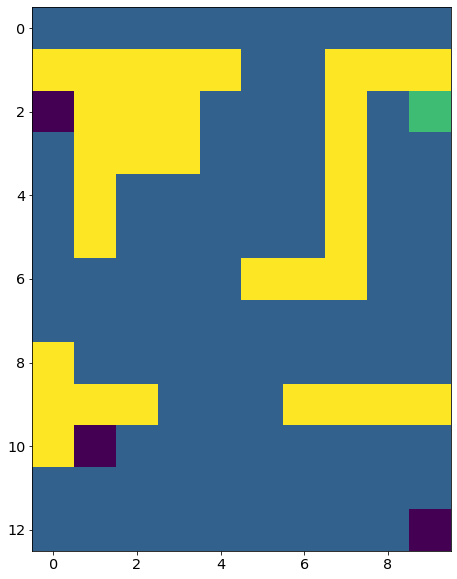

NameError: name 'MC_agent_plot' is not defined

In [270]:
#plotting stuff
maze = Maze()

repeats = [30]
episodes = [500]

fix_ep_change_rep_err = [[[] for i in range(len(repeats))] for j in range(len(episodes))]


for i in range(len(episodes)):
    for j in range(len(repeats)):
        run = 0
        while run < repeats[j]:
            run += 1
            mc_agent = MC_agent_plot()
            mc_policy, mc_values, total_rewards, _ = mc_agent.solve(maze, episodes[i])
            error = mean_squared_error(mc_values[0], dp_value)
            fix_ep_change_rep_err[i][j].append(error)
    print(f"done with {episodes[i]} episodes")



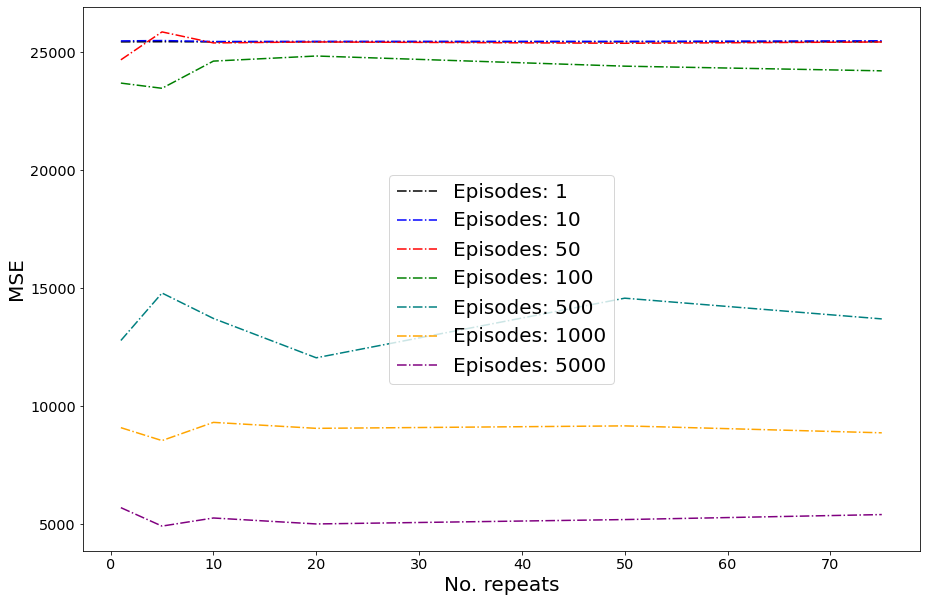

In [21]:
#GETTING VALUES CHANGE REPEATS ERROR

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


def plot_errors(values_list, xlabel, color, label):
    mean = list(map(lambda x: (np.mean(x)), values_list))
    std = list(map(lambda x: (np.std(x)), values_list))
    plt.plot(repeats, mean, '-.',color = color, label = f"{label}")
    # plt.errorbar(repeats, mean,yerr = std, color = color, capsize = 5, linestyle = '-.')
    plt.xlabel(f"{xlabel}", fontsize = 20)
    plt.ylabel("MSE", fontsize = 20)
    plt.legend( fontsize = 20)

colors = ['black', 'blue', 'red', 'green', 'teal', 'orange', 'purple']
labels = ['1', '5', '10', '20', '50', '100']

for i in range(7):
    plot_errors(fix_ep_change_rep_err[i], xlabel = 'No. repeats', color = colors[i], label = f"Episodes: {episodes[i]}")


plt.savefig('MC_MSE_vs_repeats_no_EB.png')


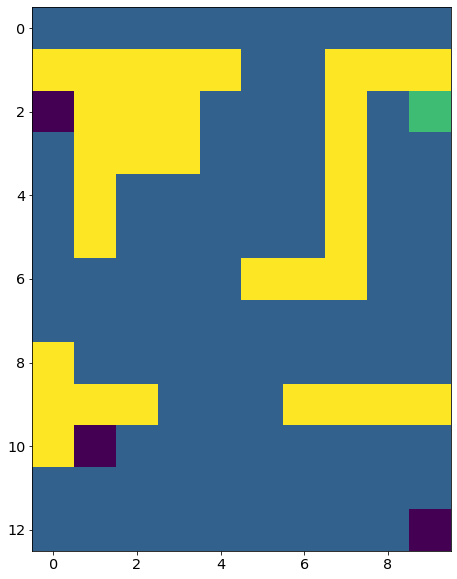

ValueError: too many values to unpack (expected 3)

In [21]:
#PLOTTING MC CHANGE EPISODES ERROR
repeats = 5
episodes = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
maze = Maze()

change_ep_err = [[] for j in range(len(episodes))]


for i in range(len(episodes)):
    run = 0
    while run < repeats:
        run += 1
        mc_agent = MC_agent_plot()
        mc_policy, mc_values, total_rewards = mc_agent.solve(maze, episodes[i])
        error = mean_squared_error(mc_values[0], dp_value)
        change_ep_err[i].append(error)
    print(f"done with {episodes[i]} episodes")


ERR:  9


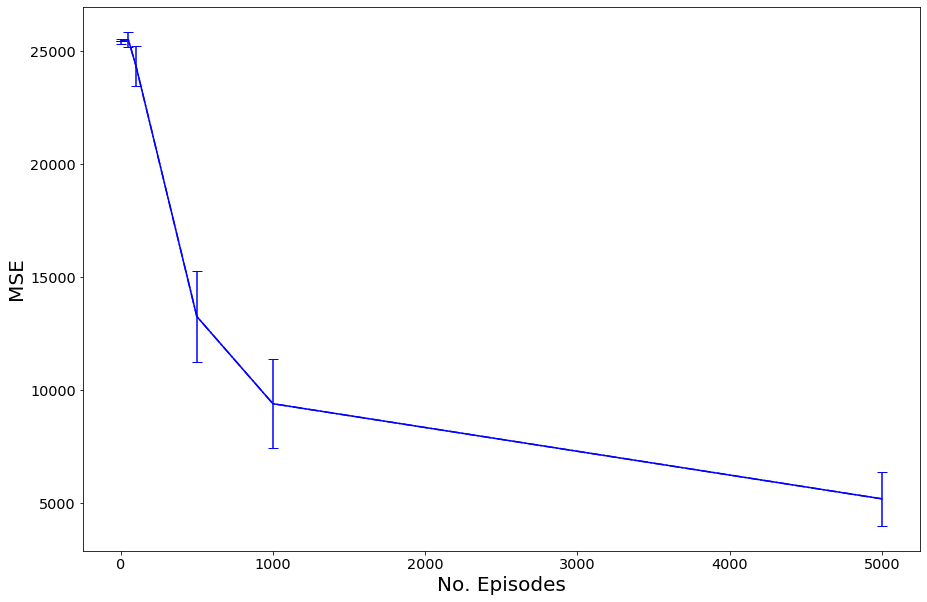

In [89]:
# PLOTTING MC ERRORS BY NUMBER OF EPISODES

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
print("ERR: ", len(change_ep_err))

def plot_errors(values_list, xlabel, color):
    mean = list(map(lambda x: (np.mean(x)), values_list))
    std = list(map(lambda x: (np.std(x)), values_list))
    plt.plot(episodes, mean, '-.',color = color)
    plt.errorbar(episodes, mean,yerr = std, color = color, capsize = 5, linestyle = '-.')
    plt.xlabel(f"{xlabel}", fontsize = 20)
    plt.ylabel("MSE", fontsize = 20)

plot_errors(change_ep_err, xlabel = 'No. Episodes', color = 'blue')


plt.savefig('MC_MSE_vs_episodes.png')


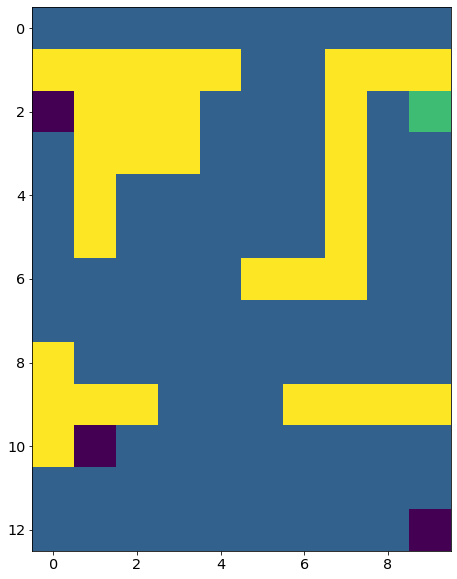

Done for repeat 0
Done for repeat 1
Done for repeat 2
Done for repeat 3
Done for repeat 4
Done for repeat 5
Done for repeat 6
Done for repeat 7
Done for repeat 8
Done for repeat 9


In [40]:
#MC CALCULATING AVERAGE RETURN PER EPISODE
returns_dict = {}
maze = Maze()
repeats = 10
mc_agent_plot = MC_agent_plot()
for i in range(repeats):
    _,_,_,returns = mc_agent_plot.solve(maze, 10000)
    returns_dict[i] = returns
    print(f"Done for repeat {i}")


    

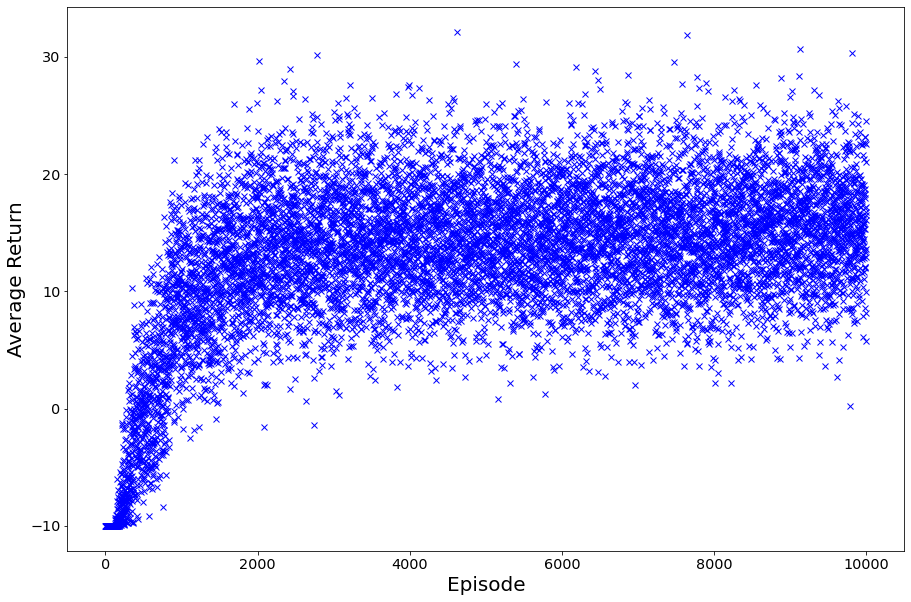

In [41]:
# PLOTTING MC AVERAGE RETURNS BY EPISODE
def plot_avg_ret_errors(returns_dict):
    vals = list(returns_dict.keys())
    returns_list = [[] for i in range(10000)]
    for val in vals:
        for j in range(10000):
            returns_list[j].append(returns_dict[val][j])
    means = list(map(lambda x: np.mean(x), returns_list))
    stds = list(map(lambda x: np.std(x), returns_list))
    
    x = [rep for rep in range(10000)]
    plt.plot(x, means, 'x',color = 'blue')
    # plt.errorbar(x, means,yerr = stds, color = 'blue', capsize = 5, linestyle = '-.')
    plt.xlabel(f"Episode", fontsize = 20)
    plt.ylabel("Average Return", fontsize = 20)

colors = ['black', 'blue', 'red', 'green', 'teal', 'orange', 'purple']
count = 0
plot_avg_ret_errors(returns_dict)

In [9]:
# This class define the Monte-Carlo agent

#MC FOR PLOTTING


class MC_agent_plot(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script

  def get_action(self, Q_state, epsilon):
    max_val = np.argmax(Q_state)
    rand_val = np.random.uniform(0,1)
    if rand_val < (1-epsilon):
      return max_val
    else:
      options = []
      for idx in range(len(Q_state)):
        if idx != max_val:
          options.append(idx)
      return np.random.choice(options)


  def solve(self, env, num_runs):
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    epsilon = 0.01
    alpha = 0.01
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    gamma = env.get_gamma()
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    # policy[:, 0] = np.argmax(Q, axis=1)
    for state in range(len(Q)):
      policy[state][np.argmax(Q[state])] = 1

    values = [V]

    # total_rewards = [[[] for i in range(env.get_action_size())] for j in range(env.get_state_size())]
    total_rewards = [[[0,0] for i in range(env.get_action_size())] for j in range(env.get_state_size())]
    total_returns = [0 for i in range(num_runs)]
    run = 0
    while run < num_runs:
      visited = {}
      run += 1
      time, env_state, reward, Terminate = env.reset()
      S_arr = np.array([], dtype = int)      
      A_arr = np.array([], dtype = int)
      R_arr = np.array([], dtype = int)
      R_arr = np.append(R_arr, 0)

      while not Terminate:
        action = self.get_action(Q[env_state], epsilon)
        S_arr = np.append(S_arr, env_state)
        A_arr = np.append(A_arr, action)
        sa_pair = (env_state, action)
        if sa_pair not in visited:
          visited[sa_pair] = time

        time, env_state, reward, Terminate = env.step(action)
        R_arr = np.append(R_arr, reward) 

      G = 0
      T = len(S_arr)

      for t in range(T-1, -1, -1):

        St = S_arr[t]; At = A_arr[t]
        # G = G + R_arr[t+1]
        G = (G * gamma) + R_arr[t+1]

        total_rewards[St][At][0] += 1
        # total_rewards[St][At][1] = total_rewards[St][At][1] + ((G - total_rewards[St][At][1]) / total_rewards[St][At][0])
        total_rewards[St][At][1] = total_rewards[St][At][1] + ((G - total_rewards[St][At][1]) * alpha)

        Q[St][At] = total_rewards[St][At][1]

        best_action = np.argmax(Q[St])
        V[St] = np.max(Q[St])
        for a in range(len(Q[St])):
          if a == best_action:
            policy[St][a] = 1 - epsilon + (epsilon/len(Q[St]))
          else:
            policy[St][a] = (epsilon/len(Q[St]))
      total_returns[run-1] += G

    for j in range(len(Q)):
      V[j] = np.max(Q[j])
    
    return policy, values, total_rewards, total_returns

In [10]:
# This class define the Temporal-Difference agent

# TD PLOTTING


class TD_agent_plot(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script

  def get_action(self, Q_state, epsilon):
    max_val = np.argmax(Q_state)
    rand_val = np.random.uniform(0,1)
    if rand_val < (1-epsilon):
      return max_val
    else:
      options = []
      for idx in range(len(Q_state)):
        if idx != max_val:
          options.append(idx)
      return np.random.choice(options)

  def solve(self, env, runs):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    alpha = 0.01
    total_returns = np.array([])
    Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
    V = np.zeros(env.get_state_size())
    policy = np.zeros((env.get_state_size(), env.get_action_size())) 
    values = [V]
    total_rewards = []
    tot_runs = runs
    epsilon = 0.01
    gamma = env.get_gamma()
    run = 0
    while run < tot_runs: 
      run += 1
      time, old_state, reward, Terminate = env.reset()
      old_action = self.get_action(Q[old_state], epsilon)
      while not Terminate:
        
        time, new_state, reward, Terminate = env.step(old_action)
        # new_action = self.get_action(Q[new_state], epsilon)
        new_action = np.argmax(Q[new_state])
        Q[old_state][old_action] = Q[old_state][old_action] + (alpha * (reward + (gamma*Q[new_state][new_action]) - Q[old_state][old_action]))
        
        old_state = new_state 
        old_action = new_action

        total_returns[run-1] += reward

    values = [np.max(Q, axis = 1)]
    for state in range(len(Q)):
      policy[state][np.argmax(Q[state])] = 1
    total_rewards = 0
    
    return policy, values, total_rewards, total_returns